# Import packages

In [1]:
import os
import re
import time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant

import yahoo_crawler
yc = yahoo_crawler.yahoo_crawler()

yahooo_crawler


In [2]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.facecolor'] = '1.'
plt.rcParams["axes.axisbelow"] = False

# Update local stock list

In [3]:
def update_stocklist_data():
    ''' Functions for update stocklist data
    Source: www.nasdaq.com
    '''
    # create stock_list data folder
    folder = os.getcwd() + '\\stock_list\\'
    if not os.path.exists(folder):
        os.makedirs(folder)

    # soure url
    url = 'https://www.nasdaq.com/screening/companies-by-name.aspx?letter=0&exchange=%s&render=download'

    # available exhanges
    exchange = ['nasdaq', 'nyse', 'amex']

    for exchg in exchange:
        resp = requests.get(url%exchg)
        with open(folder + '%s.xlsx'%exchg, 'wb') as output:
            output.write(resp.content)
    pass

# update stock_list
update_stocklist_data()

# Read local stock list

In [4]:
# data folder
folder = os.getcwd() + '\\stock_list\\'

# file names
files = os.listdir( folder )

stolis_df_list = []
for f in files:
    df = pd.read_csv( folder + f )
    stolis_df_list.append(df)
    print(f.upper(),df.shape, '\n==================================================\n',
          df[['Name']].head() )
    print('==================================================\n')

# concatenate companies from three exhanges
stolis_df_ = pd.concat(stolis_df_list, axis = 0)

# drop out fund
stolis_df_ = stolis_df_[stolis_df_['industry'] == stolis_df_['industry']]

# drop dupplicated company names
stolis_df = stolis_df_.drop_duplicates(['Name']).reset_index(drop = True)

print('Total %s companies, unique %s companies.' % (stolis_df_.shape[0], stolis_df.shape[0]))

AMEX.XLSX (309, 9) 
                                                 Name
0                            22nd Century Group, Inc
1              Aberdeen Asia-Pacific Income Fund Inc
2                 Aberdeen Australia Equity Fund Inc
3  Aberdeen Emerging Markets Equity Income Fund, ...
4                  Aberdeen Global Income Fund, Inc.

NASDAQ.XLSX (3447, 9) 
                                      Name
0                               111, Inc.
1  1347 Property Insurance Holdings, Inc.
2  1347 Property Insurance Holdings, Inc.
3                180 Degree Capital Corp.
4                 1-800 FLOWERS.COM, Inc.

NYSE.XLSX (3108, 9) 
                      Name
0  3D Systems Corporation
1              3M Company
2         500.com Limited
3             58.com Inc.
4                 8x8 Inc

Total 5304 companies, unique 4793 companies.


# Fetch yahoo finance stock data

In [5]:
def get_stock_data(symbol, start, end,):
    t = time.time()
    cookie,crumb = yc.get_yahoo_crumb_cookie()

    symbol = symbol# stock id
    params = {'period1' : start,
              'period2' : end,
              'interval': '1d',
              'events'  : 'history',
              'crumb'   : crumb}
    df = yc.GetStockPrice(symbol = symbol,
                               params = params,
                               request_type = 'post')
    
    # set date as index
    df = df.set_index('Date')
    df.sort_index(inplace = True)
    
    t2 = time.time() - t
    print(str(round(t2,4))+' seconds elapsed...')
    return df[['Adj Close']]

In [6]:
# define trading dates with S&P index
SP500          = get_stock_data(symbol = '^GSPC', start = '2016-12-01', end = '2019-04-19')
standard_index = SP500.index

Connected! It's the 1/200 try...
0.8125 seconds elapsed...


In [7]:
def reindex_data(symbol, tweets_date, standard_index = standard_index, how = 'test'):
    
    assert how in ['test', 'train'], 'Parameter *how* must be either \'test\' or \'train\'!'
    
    if how == 'test':
        start = standard_index[ standard_index <  tweets_date][-11]
        end   = standard_index[ standard_index >= tweets_date][ 11]

        df = get_stock_data(symbol = symbol, start = start, end = end)

        df = df.reindex(standard_index)

        df_ = pd.concat([ df[ df.index <  tweets_date ].tail(10),
                          df[ df.index >= tweets_date ].head(11) ])
    
    elif how == 'train':
        start = standard_index[ standard_index <  tweets_date][-252]
        end   = standard_index[ standard_index >= tweets_date][  11]

        df = get_stock_data(symbol = symbol, start = start, end = end)

        df = df.reindex(standard_index)

        df_ = pd.concat([ df[ df.index <  tweets_date ].tail(251),
                          df[ df.index >= tweets_date ].head(11) ])
        
    return df_

# Fetch marked tweets data

In [8]:
tweets = pd.read_excel('marked_tweets.xlsx')
tweets.head()

,tweets,companies,created_at
0,why would smart voters want to put democrats ...,"['PUHUI WEALTH INVESTMENT MANAGEMENT CO., LTD.']",2017-12-31 13:36:32
1,big protests in iran. the people are finally ...,"['PUHUI WEALTH INVESTMENT MANAGEMENT CO., LTD.']",2017-12-31 13:03:29
2,"i use social media not because i like to, but...","['Pure Cycle Corporation', 'Pure Storage, Inc....",2017-12-30 22:36:41
3,on taxes: “this is the biggest {CORPORATE} ...,"['Corporate Asset Backed Corp CABCO', 'Corpora...",2017-12-30 21:12:45
4,many reports of peaceful protests by iranian ...,"['ZTO Express (Cayman) Inc.', 'Express, Inc.',...",2017-12-30 03:42:58


In [9]:
tweets_i = tweets.iloc[2,:]
tweets_i

tweets         i use social media not because i like to, but...
companies     ['Pure Cycle Corporation', 'Pure Storage, Inc....
created_at                                  2017-12-30 22:36:41
Name: 2, dtype: object

In [10]:
symbol = stolis_df['Symbol'][(stolis_df['Name'] == eval(tweets_i['companies'])[0])].values[0]
symbol

'PCYO'

In [11]:
def my_normalize(df):
    df = df.copy()
    df -= df.mean()
    df /= df.std()
    return df

test_S_i = reindex_data(symbol = symbol, tweets_date = tweets_i['created_at'])

test_S_m = SP500.reindex(test_S_i.index)

test_set = pd.concat([my_normalize(test_S_i), my_normalize(test_S_m) ], axis = 1)
test_set.columns = ['S_i', 'S_m']
test_set.plot()

In [12]:
def fetch_data_set(symbol, tweets_date, plot = False):
    S_i = reindex_data(symbol = symbol, tweets_date = tweets_date, how = 'train')

    S_m = SP500.reindex(S_i.index)

    df = pd.concat([S_i, S_m ], axis = 1)
    df.columns = ['S_i', 'S_m']
    
    assert len(df[df['S_i'] != df['S_i']]) < 10, 'Missing values of stock %s are more than 10!'%symbol
    
    if plot:
        fig = plt.figure()
        plt.plot(my_normalize(df['S_i']), label = symbol)
        plt.plot(my_normalize(df['S_m']), label = 'S&P500' )
        plt.title('Data set (normalized)')
        plt.ylabel('Normalize price serires')
        plt.legend()
        plt.grid()
        plt.show()
        
    return df

Connected! It's the 1/200 try...
0.8061 seconds elapsed...


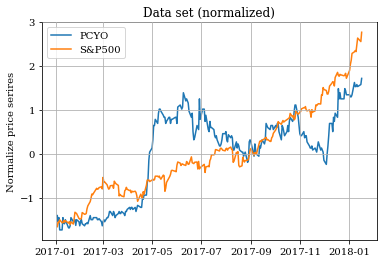

(262, 2)

In [13]:
df = fetch_data_set(symbol, tweets_i['created_at'], plot = True)
df.shape

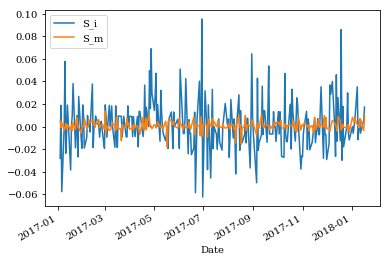

In [14]:
ret = np.log(df).diff().dropna()
ret.plot()

In [15]:
X = add_constant(ret['S_m'].iloc[: 240])
model = OLS(ret['S_i'].iloc[: 240], X).fit()

In [16]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    S_i   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.163
Date:                Sat, 20 Apr 2019   Prob (F-statistic):              0.143
Time:                        15:24:10   Log-Likelihood:                 575.27
No. Observations:                 240   AIC:                            -1147.
Df Residuals:                     238   BIC:                            -1140.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      0.791      0.430      -0.002       0.004
S_m            0.5002      0.340      1.471      0.143      -0.170       1.170
==============================================================================
Omnibus:                       25.192   Durbin-Watson:                   2.262
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.028
Skew:                           0.561   Prob(JB):                     6.14e-11
Kurtosis:                       4.856   Cond. No.                         238.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""